In [1]:
from matplotlib import pyplot as plt

from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from skimage.io import imread
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, Lambda, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 20

Using TensorFlow backend.


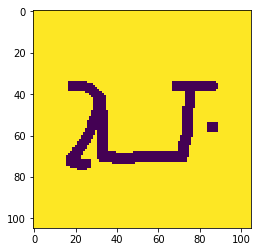

In [4]:
test = imread('../images/omniglot/images_background/Alphabet_of_the_Magi/character01/0709_01.png')

In [7]:
def get_images(filepath, image_dims=(105,105)):
    """
    Get pairs of images from a csv which contains paths in the first 2 columns.
    """
    arr = np.genfromtxt(filepath, dtype = np.unicode_, delimiter = ',')
    out = np.empty((len(arr), 2, image_dims[0], image_dims[1]))
    out[:,0] = [imread(pp) for pp in arr[:,0]]
    out[:,1] = [imread(pp) for pp in arr[:,1]]
    out = out.astype('float32')
    
    return out

def interleave_arrays(arr1, arr2):
    """
    Create an array with alternating rows from two arrays.
    Assumes the two arrays have the same dtype and dimensions.
    """
    newshape = list(arr1.shape)
    newshape[0] *= 2
    out = np.empty(newshape, dtype = arr1.dtype)
    out[0::2] = arr1
    out[1::2] = arr2
    
    return out

In [56]:
# Testing interleave_arrays()
arr1 = np.array([[1,2,3],[7,8,9]])
arr2 = np.array([[4,5,6],[10,11,12]])
interleave_arrays(arr1, arr2)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [28]:
# Testing get_images()
arr = get_images('../images/omniglot/test_same_pairs.csv')

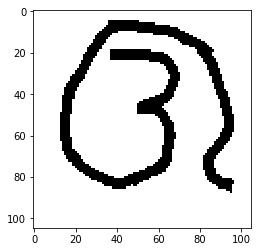

In [29]:
plt.imshow(arr[0,0], cmap='gray')
plt.show()

In [6]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def l1_distance(vects):
    x, y = vects
    return K.maximum(K.sum(K.abs(x - y), axis=1, keepdims=True), K.epsilon())


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def l1_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return(shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size = (10, 10), activation='relu')(input)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Conv2D(filters = 128, kernel_size = (7,7), activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Conv2D(filters = 128, kernel_size = (4,4), activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Conv2D(filters = 256, kernel_size = (4,4))(x)
    x = Flatten()(x)
    x = Dense(4096, activation ='sigmoid')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [8]:
# Creating training and test data
image_dims = (105, 105)

train_same = get_images('../images/omniglot/train_same_pairs.csv', image_dims)
train_diff = get_images('../images/omniglot/train_different_pairs.csv', image_dims)
test_same = get_images('../images/omniglot/test_same_pairs.csv', image_dims)
test_diff = get_images('../images/omniglot/test_different_pairs.csv', image_dims)

tr_pairs = interleave_arrays(train_same, train_diff) / 255
te_pairs = interleave_arrays(test_same, test_diff) / 255
tr_y = np.zeros((len(tr_pairs),))
tr_y[0::2] = 1
te_y = np.zeros((len(te_pairs),))
te_y[0::2] = 1

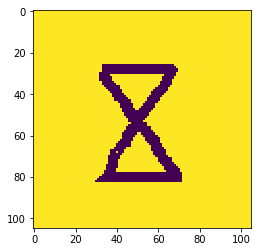

In [13]:
plt.imshow(tr_pairs[1,1,:,:])
plt.show()

In [14]:
# network definition
# Input shape is dim. of image and number of channels (1 channel here)
input_shape = (105, 105, 1)
base_network = create_base_network(input_shape)

In [15]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(l1_distance,
                  output_shape=l1_dist_output_shape)([processed_a, processed_b])

sig_out = Dense(1, activation='sigmoid')(distance)

model = Model([input_a, input_b], sig_out)

In [22]:
rms = RMSprop()  # optimization method: variant of SGD
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

# Note that the training and test images need to be reshaped to add channel information (1 channel)
model.fit([tr_pairs[:, 0].reshape(30000, 105, 105, 1), 
           tr_pairs[:, 1].reshape(30000, 105, 105, 1)], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0].reshape(10000, 105, 105, 1), 
                            te_pairs[:, 1].reshape(10000, 105, 105, 1)], te_y))

Train on 30000 samples, validate on 10000 samples
Epoch 1/20
 2048/30000 [=>............................] - ETA: 1:02:30 - loss: 0.3386 - accuracy: 0.4961

KeyboardInterrupt: 

In [ ]:
# compute final accuracy on training and test sets
## NOTE: I haven't tried this section yet, so we might need to reshape the data here too
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))